# Ⅳ. 회귀와 예측

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1. 단순선형회귀
---
- 응답변수(response variable): 예측하고자 하는 변수
    - 유의어 - 반응변수, 종속변수, 변수 Y, 목표, 출력(output)
- 독립변수(independent variable): 응답치를 예측하기 위해 사용되는 변수
    - 유의어 - 예측변수, 변수 X, 피처, 속성
- 레코드(record): 한 특정 경우에 대한 입력과 출력을 담고 있는 벡터
    - 유의어 - 행, 사건, 예시(instance), 예제(example)
- 절편(intecept): 회귀직선의 절편. 즉 $X=0$일 때 예측값
    - 유의어 - $b_0$, $\beta_0$
- 회귀계수(regression coefficient): 회귀직선의 기울기
    - 유의어 - 기울기(slope), $b_1$, $\beta_1$, 모수 추정값, 가중치
- 적합값(fitted value): 회귀선으로부터 얻은 추정치 $\hat{Y_i}$
    - 유의어 - 예측값
- 잔차(residual): 관측값과 적합값의 차이
    - 유의어 - 오차
- 최소제곱(least square): 잔차의 제곱합을 최소화하여 회귀를 fitting하는 방법
    - 유의어 - 보통최소제곱, OLS

- 상관관계 vs 회귀
    - 상관관계
        - 두 변수 사이의 전체적인 관련 강도
        - 변수 $X$와 $Y$가 서로 바뀌어도 상관 없음
    - 회귀
        - 관계 자체를 정량화하는 방법
        - 변수 $X$로부터 변수 $Y$를 예측

### A. 회귀식
---
- $Y=b_0+b_1X$

In [3]:
lung = pd.read_csv('../data/LungDisease.csv')

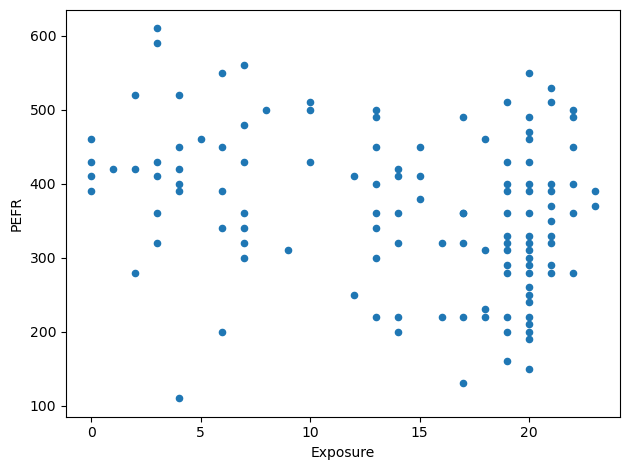

In [4]:
# 산점도
lung.plot.scatter(x='Exposure', y='PEFR')

plt.tight_layout()
plt.show()

In [5]:
# scikit-learn의 LinearRegression 모델
# 절편과 회귀계수
predictors = ['Exposure']
outcome = 'PEFR'

model = LinearRegression()
model.fit(lung[predictors], lung[outcome])

print(f'Intercept: {model.intercept_:.3f}')
print(f'Coefficient Exposure: {model.coef_[0]:.3f}')

Intercept: 424.583
Coefficient Exposure: -4.185


- 절편 $b_0$ - 424.583으로 이는 노동자가 노출된 연(year)수가 0일 때 예측되는 PEFR이라고 볼 수 있음
- 회귀계수 $b_1$ - 노동자가 면진에 노출되는 연수가 1씩 증가할 때마다 PEFR은 -4.185의 비율로 감소한다고 볼 수 있음

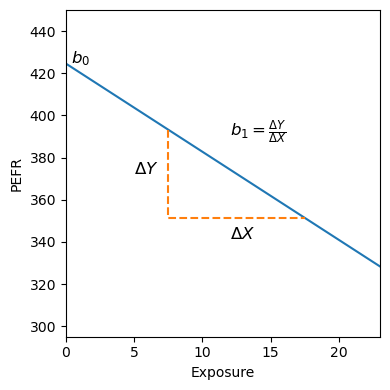

In [6]:
# 회귀선
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(0, 23)
ax.set_ylim(295, 450)
ax.set_xlabel('Exposure')
ax.set_ylabel('PEFR')
ax.plot((0, 23), model.predict(pd.DataFrame({'Exposure': [0, 23]})))
ax.text(0.4, model.intercept_, r'$b_0$', size='larger')

x = pd.DataFrame({'Exposure': [7.5,17.5]})
y = model.predict(x)
ax.plot((7.5, 7.5, 17.5), (y[0], y[1], y[1]), '--')
ax.text(5, np.mean(y), r'$\Delta Y$', size='larger')
ax.text(12, y[1] - 10, r'$\Delta X$', size='larger')
ax.text(12, 390, r'$b_1 = \frac{\Delta Y}{\Delta X}$', size='larger')

plt.tight_layout()
plt.show()

### B. 적합값과 잔차
---
- 적합값(예측값)과 잔차(예측 오차)는 회귀분석에서 중요한 개념임
- 보통 모든 데이터가 정확히 한 직선 안에 들어오지 않음 -> 회귀식은 명시적으로 오차항 $e_i$ 포함
    - $Y_i=b_0+b_1X_i+e_i$
- 적합값은 예측값을 지칭하는 말로, 보통 $\hat{Y_i}$로 나타냄
    - $hat{Y_i} = \hat{b_0} + \hat{b_1}X_i$
    - $\hat{e_i}=Y_i-\hat{Y_i}$

```
햇(^) 표기법

정확히 모르는 어떠한 값의 추정치를 의미할 때 쓰이는 기호 ^(햇, hat)
```

In [7]:
# 적합값과 잔차
fitted = model.predict(lung[predictors])
residuals = lung[outcome] - fitted

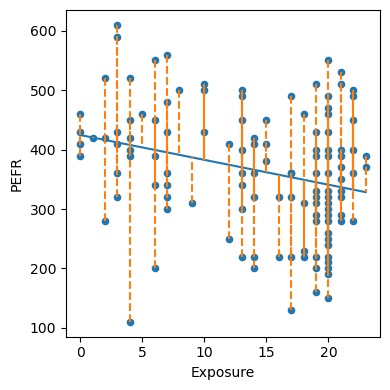

In [8]:
ax = lung.plot.scatter(x='Exposure', y='PEFR', figsize=(4, 4))
ax.plot(lung.Exposure, fitted)
for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted):
    ax.plot((x, x), (yactual, yfitted), '--', color='C1')

plt.tight_layout()
plt.show()

### C. 최소제곱
---
- 실무에서 회귀선은 잔차제곱합(RSS)을 최소화하는 선
    - $RSS\\=\sum_{i=1}^n \left(Y_i-\hat{Y_i}\right)^2\\=\sum_{i=1}^n \left(Y_i-\hat{b_0}-\hat{b_1}X_i\right)^2$
- 추정치 $\hat{b_0}$와 $\hat{b_1}$은 RSS를 최소화하는 값
- RSS를 최소화하는 이러한 방법을 최소제곱회귀 혹은 보통최소제곱(OLS)회귀라고 함

### D. 예측 대 설명(프로파일링)

```
회귀방정식 자체가 인과관계를 정확히 증명하는 것은 아니다.
인과관계에 대한 결론은 그 관계에 대한 더 폭넓은 이해를 바탕으로 해야 한다.
예를 들어 웹 광고에서 클릭 수와 전환률 간의 명확한 관계를 보여줄 때 회귀방정식이 쓰일 수 있지만, 이는 마케팅 프로세스에 대한 지식을 발휘하여 이끌어내는 결론이다.
-> 회귀방정식을 시각화 방법처럼 쓸 수는 있지만 결론에 대한 근거로 쓰는 것에는 무리가 있다.
```

## 2. 다중선형회귀
---
- 제곱근평균제곱오차(RMSE): 회귀 시 평균제곱오차의 제곱근으로, *회귀모형을 평가*하는 데 가장 널리 사용되는 측정 지표
- 잔차표준오차(RSE): 평균제곱오차와 동일하지만 *자유도에 따라 보정*된 값
- R 제곱(r-squared): 0에서 1까지 모델에 의해 설명된 분산의 비율
    - 유의어 - 결정계수(coefficient of determination,$R^2$)
- t 통계량(t-statistic): 계수의 표준오차로 나눈 예측변수의 계수로, 모델에서 *변수의 중요도*를 비교하는 기준이 됨
- 가중회귀(weighted regression): 다른 가중치를 가진 레코드들을 회귀하는 방법

- 회귀식 - $Y=b_0+b_1X_1+b_2X_2+\cdots+b_pX_p+e$
- 적합값 - $\hat{Y_i}=\hat{b_0}+\hat{b_1}X_1+\hat{b_2}X_2+\cdots+\hat{b_p}X_{p,i}$

### A. 예제 (킹 카운티 주택 정보)

In [9]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms',
          'Bedrooms', 'BldgGrade']

house = pd.read_csv('../data/house_sales.csv', sep='\t')
print(house[subset].head())

   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1      300805.0           2400     9373       3.00         6          7
2     1076162.0           3764    20156       3.75         4         10
3      761805.0           2060    26036       1.75         4          8
4      442065.0           3200     8618       3.75         5          7
5      297065.0           1720     8620       1.75         4          7


In [10]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms',
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -521871.368
Coefficients:
 SqFtTotLiving: 228.83060360240742
 SqFtLot: -0.06046682065303946
 Bathrooms: -19442.84039832103
 Bedrooms: -47769.95518521429
 BldgGrade: 106106.96307898096


다른 모든 변수 $X_k$(단 $k≠j$)가 고정되었다고 가정했을 때, $X_j$가 변하는 정도에 따라, 예측값 $\hat{Y}$도 계수 $b_j$에 비례해 변화한다.

### B. 모형 평가 
---
- 제곱근평균제곱오차(RMSE)
    - 예측된 $\hat{y_i}$ 값들의 평균제곱오차의 제곱근
    - 분모=데이터 수
    - $RMSE=\sqrt{{\sum_{i=1}^n \left(y_i-\hat{y_i}\right)^2}\over n}$
- 잔차표준오차(RSE)
    - 분모=자유도
    - 독립변수가 $p$개
    - $RSE=\sqrt{{\sum_{i=1}^n \left(y_i-\hat{y_i}\right)^2}\over {n-p-1}}$
- 결정계수=$R$ 제곱 통계량=$R^2$
    - 0에서 1까지 범위
    - 모델 데이터의 변동률 측정
    - 모델이 데이터에 얼마나 적합한지 평가하고자 할 때, 회귀분석을 설명하기 위한 용도
    - $R^2=1-{{\sum_{i=1}^n \left(y_i-\hat{y_i}\right)^2} \over {\sum_{i=1}^n \left(y_i-\bar{y}\right)^2}}$
- 수정 $R$ 제곱(adjusted r-squared)
    - 모델에 더 많은 독립변수를 추가하는 것에 대해 효과적으로 패널티를 가함
- t 통계량
    - <ins>t 통계량이 높을수록(p 값이 낮을수록)</ins> 독립변수는 더욱 유의미함
    - SE=계수의 표준오차
    - $t_b={\hat{b} \over SE\left(\hat{b}\right)}$

In [11]:
# scikit-learn의 r2_score
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

RMSE: 261220
r2: 0.5406


In [12]:
# statsmodels
# 절편 계산을 위한 상수 1 컬럼 추가
model = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5338.
Date:                Fri, 07 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:40:14   Log-Likelihood:            -3.1517e+05
No. Observations:               22687   AIC:                         6.304e+05
Df Residuals:                   22681   BIC:                         6.304e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.8306      3.899     58.694

### C. 교차타당성검사
---
- R^2, F 통계량, p 값 등은 모두 '표본 내(in-sample)' 지표
- '표본 밖(out-of-sample)' 유효성 검사는 더 큰 데이터 집합들이 등장하면서 유의미해짐
- 교차타당성검사(cross-validation)
    - 홀드아웃 샘플 아이디어를 여러 개의 연속된 홀드아웃 샘플로 확장한 것
    - k 다중 교차타당성검사(k-fold cross-validation)
    - **fold**: 훈련을 위한 샘플과 홀드아웃 샘플로 데이터를 나누는 것

### D. 모형 선택 및 단계적 회귀
---
- 더 많은 변수를 추가한다고 해서 꼭 더 좋은 모델을 얻는 것은 아님
- 변수를 추가할수록 항상 RMSE는 감소하고 $R^2$은 증가함
- 모델 복잡성을 함께 고려하는 한 가지 방법은 수정 $R$ 제곱 사용임
    - $n$은 레코드 수, $P$는 모델의 변수 개수
    - $R_{adj}^2=1-\left(1-R^2\right){{n-1} \over {n-P-1}}$

In [13]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated',
              'NewConstruction']

X = pd.get_dummies(house[predictors], drop_first=True, dtype=int)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2771.
Date:                Fri, 07 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:40:14   Log-Likelihood:            -3.1375e+05
No. Observations:               22687   AIC:                         6.275e+05
Df Residuals:                   22674   BIC:                         6.276e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving       

```
※ 오컴의 면도날

모든 것이 동일한 조건에서는 복잡한 모델보다는 단순한 모델을 우선 사용해야 한다는 원리
```

```
※ AIC와 AIC 변형

1. AIC
아카이케 히로쓰구가 모델에 항을 추가할수록 불이익을 주는 AIC라는 측정 기준 개발
AIC=2P+nlog(RSS/n)
2. AICc
크기가 작은 표본을 위해 수정된 AIC
3. BIC
AIC와 비슷하지만 변수 추가에 대해 더 강한 벌점을 주는 정보기준
4. 맬로즈 C_p
맬로즈가 제안한 AIC 변형
```

```
AIC를 최소화하거나 수정 R 제곱을 최대화하는 모델을 어떻게 찾을 수 있을까?

1. 부분집합회귀: 모든 가능한 모델 검색, 계산 비용이 많이 듦
2. 후진선택: 전체 모델부터 시작하여 통계적으로 유의하지 않은 변수들을 연속적으로 삭제, 통계적으로 유의미한 모델이 되면 중단
3. 전진선택: 상수 모델에서 시작하여 R^2에 가장 큰 기여도를 갖는 변수를 하나씩 추가, 기여도가 통계적으로 더는 유의미하지 않을 때 중단
4. 단계적선택: 연속적이로 변수를 제거 혹은 추가
```

In [14]:
# dmba의 stepwise_selection
y = house[outcome]

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model,
                                                verbose=True)

print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=647988.32, constant
Step: score=633013.35, add SqFtTotLiving
Step: score=630793.74, add BldgGrade
Step: score=628230.29, add YrBuilt
Step: score=627784.16, add Bedrooms
Step: score=627602.21, add Bathrooms
Step: score=627525.65, add PropertyType_Townhouse
Step: score=627525.08, add SqFtFinBasement
Step: score=627524.98, add PropertyType_Single Family
Step: score=627524.98, unchanged None

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.2775530420155
 BldgGrade: 137159.56022619738
 YrBuilt: -3565.42493924946
 Bedrooms: -51947.38367361344
 Bathrooms: 42396.16452772067
 PropertyType_Townhouse: 84479.16203300114
 SqFtFinBasement: 7.046974967575435
 PropertyType_Single Family: 22912.055187017802


```
※ 벌점회귀

개념적으로 AIC와 같다. 
앞서 소개된 방법들처럼 예측변수를 완전히 제거하는 대신 계수 크기를 감소시키거나 거의 0으로 만든다.
능형회귀와 라소를 많이 사용한다.
```

### E. 가중회귀
---
- 가중회귀의 유용성
    1. 첫번째 관점
        - 서로 다른 관측치를 다른 정밀도로 측정했을 때, <ins>역분산 가중치를 얻을 수 있음</ins>
        - 분산이 높을수록 가중치가 낮음
    1. 두번째 관점
        - 가중치 변수가 집계된 데이터의 각 행이 나타내는 원본 관측치의 수를 인코딩하도록, <ins>행이 여러 경우를 의미하는 데이터를 분석할 수 있음</ins>

In [15]:
house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]
house['Year'] = house.DocumentDate.apply(lambda d: int(d.split('-')[0]))
house['Weight'] = house.Year - 2005

In [16]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms',
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house.Weight)

pd.concat([
    pd.DataFrame({
        'predictor': predictors,
        'house_lm': house_lm.coef_,
        'house_wt': house_wt.coef_,
    }),
    pd.DataFrame({
        'predictor': ['intercept'],
        'house_lm': house_lm.intercept_,
        'house_wt': house_wt.intercept_,
    })
])

,predictor,house_lm,house_wt
0,SqFtTotLiving,228.830604,245.024089
1,SqFtLot,-0.060467,-0.292415
2,Bathrooms,-19442.840398,-26085.970109
3,Bedrooms,-47769.955185,-53608.876436
4,BldgGrade,106106.963079,115242.434726
0,intercept,-521871.368188,-584189.329446


In [17]:
residuals = pd.DataFrame({
    'abs_residual_lm': np.abs(house_lm.predict(house[predictors]) - house[outcome]),
    'abs_residual_wt': np.abs(house_wt.predict(house[predictors]) - house[outcome]),
    'Year': house['Year'],
})
print(residuals.head())
# axes = residuals.boxplot(['abs_residual_lm', 'abs_residual_wt'], by='Year', figsize=(10, 4))
# axes[0].set_ylim(0, 300000)

pd.DataFrame(([year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt'])]
              for year, group in residuals.groupby('Year')),
             columns=['Year', 'mean abs_residual_lm', 'mean abs_residual_wt'])
# for year, group in residuals.groupby('Year'):
#     print(year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt']))

   abs_residual_lm  abs_residual_wt  Year
1    123750.814194    107108.553965  2014
2     59145.413089     96191.882094  2006
3    190108.725716    187004.492880  2007
4    198788.774412    196132.996857  2008
5     91774.996129     84277.577512  2013


,Year,mean abs_residual_lm,mean abs_residual_wt
0,2006,140540.303585,146557.454636
1,2007,147747.577959,152848.523235
2,2008,142086.905943,146360.411668
3,2009,147016.720883,151182.924825
4,2010,163267.674885,166364.476152
5,2011,169937.385744,172950.876028
6,2012,169506.670053,171874.424266
7,2013,203659.777510,206242.199403
8,2014,184452.840665,186668.573750
9,2015,172323.435147,169842.742053


## 3. 회귀를 이용한 예측
---
- 예측구간(prediction interval): 개별 예측값 주위의 불확실한 구간
- 외삽법(extrapolation): 모델링에 사용된 데이터 범위를 벗어난 부분까지 모델을 확장하는 것

### A. 외삽의 위험

### B. 신뢰구간과 예측구간

## 4. 회귀에서의 요인변수
---
- 가변수(dummy variable): 회귀나 다른 모델에서 요인 데이터를 사용하기 위해 0과 1의 이진변수로 부호화한 변수
- 기준 부호화(reference coding): 통계학자들이 많이 사용하는 부호화
    - 유의어 - 처리 부호화(treatment coding)
- 원-핫 인코딩(one-hot encoding): 머신러닝 분야에서 많이 사용되는 부호화
- 편차 부호화(deviation coding): 기준 수준과는 반대로 전체 평균에 대해 각 수준을 비교하는 방법
    - 유의어 - 총합 대비(sum contrast)
- 다항식 부호화(polynomial coding): 순서가 있는 요인변수에 적합

### A. 가변수 표현

In [18]:
print(house.PropertyType.head())

1        Multiplex
2    Single Family
3    Single Family
4    Single Family
5    Single Family
Name: PropertyType, dtype: object


In [19]:
print(pd.get_dummies(house['PropertyType']).head(6))

   Multiplex  Single Family  Townhouse
1       True          False      False
2      False           True      False
3      False           True      False
4      False           True      False
5      False           True      False
6      False          False       True


In [20]:
print(pd.get_dummies(house['PropertyType'], drop_first=True).head(6))

   Single Family  Townhouse
1          False      False
2           True      False
3           True      False
4           True      False
5           True      False
6          False       True


In [21]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']

X = pd.get_dummies(house[predictors], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print(f'Intercept: {house_lm_factor.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f' {name}: {coef}')

Intercept: -446841.366
Coefficients:
 SqFtTotLiving: 223.3736289250378
 SqFtLot: -0.07036798136812013
 Bathrooms: -15979.013473415218
 Bedrooms: -50889.73218483021
 BldgGrade: 109416.30516146198
 PropertyType_Single Family: -84678.2162954924
 PropertyType_Townhouse: -115121.97921609168


### B. 다수의 수준을 갖는 요인변수들

In [22]:
house = pd.read_csv('../data/house_sales.csv', sep='\t')

In [23]:
print(pd.DataFrame(house['ZipCode'].value_counts()).transpose())

ZipCode  98038  98103  98042  98115  98117  98052  98034  98033  98059  98074  \
count      788    671    641    620    619    614    575    517    513    502   

ZipCode  ...  98051  98024  98354  98050  98057  98288  98224  98068  98113  \
count    ...     32     31      9      7      4      4      3      1      1   

ZipCode  98043  
count        1  

[1 rows x 80 columns]


In [24]:
# 초기 모델의 잔차를 사용하여 우편번호 그룹 생성
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms',
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])


zip_residuals = pd.DataFrame({
    'ZipCode': house['ZipCode'],
    'residual' : house[outcome] - house_lm.predict(house[predictors]),
})

zip_groups = pd.DataFrame([
    {
        'ZipCode': zipCode,
        'count': len(x),
        'median_residual': x.residual.median()
    }
    for zipCode, x in zip_residuals.groupby('ZipCode')
]).sort_values('median_residual')

zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False, retbins=False)
zip_groups.head()
print(zip_groups.ZipGroup.value_counts().sort_index())

ZipGroup
0    16
1    16
2    16
3    16
4    16
Name: count, dtype: int64


In [25]:
to_join = zip_groups[['ZipCode', 'ZipGroup']].set_index('ZipCode')
house = house.join(to_join, on='ZipCode')
house['ZipGroup'] = house['ZipGroup'].astype('category')

### C. 순서가 있는 요인변수

```
단순히 요인변수로 다루면 순서에 담긴 정보를 잃어버릴 수 있기에,
순서 요인변수는 수치형 변수로 다룬다.
```

## 5. 회귀방정식 해석
---
- 변수 간 상관(correlated variables): 변수들이 같은 방향으로 움직이려는 경향을 가짐
    - 예시 - 양의 상관, 음의 상관
    - 예측변수끼리 서로 상관성이 높으면 개별 계수를 해석하는 것이 어려움
- 다중공선성(multicollinearity): 독립변수들이 완벽하거나 거의 완벽에 가까운 상관성을 가짐, 이럴 때 회귀는 불안정하여 계산이 불가능함
    - 유의어 - 공선성(collinearity)
- 교란변수(confounding variable): 중요한 독립변수이지만 회귀방정식에 누락되어 결과가 잘못되게 이끄는 변수
- 주효과(main effect): 다른 변수들과 독립된, 하나의 독립변수와 종속변수 사이의 관계
- 상호작용(interaction): 둘 이상의 독립변수와 종속변수 사이의 상호의존적인 관계

### A. 예측변수 간 상관

In [26]:
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.2775530420155
 BldgGrade: 137159.56022619738
 YrBuilt: -3565.42493924946
 Bedrooms: -51947.38367361344
 Bathrooms: 42396.16452772067
 PropertyType_Townhouse: 84479.16203300114
 SqFtFinBasement: 7.046974967575435
 PropertyType_Single Family: 22912.055187017802


In [27]:
# python에선 update()와 같은 함수가 없어 새로 지정
# 상관관계가 있는 변수 제거
predictors = ['Bedrooms', 'BldgGrade', 'PropertyType', 'YrBuilt']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

reduced_lm = LinearRegression()
reduced_lm.fit(X, house[outcome])


print(f'Intercept: {reduced_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, reduced_lm.coef_):
    print(f' {name}: {coef}')

Intercept: 4913973.344
Coefficients:
 Bedrooms: 27150.537230215017
 BldgGrade: 248997.7936621371
 YrBuilt: -3211.744862155088
 PropertyType_Single Family: -19898.49534050228
 PropertyType_Townhouse: -47355.436873344705


### B. 다중공선성
---
- 다중공선성이 발생하는 경우
    - 오류로 인해 한 변수가 여러 번 포함된 경우
    - 요인변수로부터 P-1개가 아닌 P개의 가변수가 만들어진 경우
    - 두 변수가 서로 거의 완벽하게 상관성이 있는 경우

### C. 교란변수

In [28]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'ZipGroup']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f'Intercept: {confounding_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -666637.469
Coefficients:
 SqFtTotLiving: 210.61266005580174
 SqFtLot: 0.45498713854658784
 Bathrooms: 5928.425640001621
 Bedrooms: -41682.871840744825
 BldgGrade: 98541.18352725964
 PropertyType_Single Family: 19323.625287919614
 PropertyType_Townhouse: -78198.72092762396
 ZipGroup_1: 53317.173306598
 ZipGroup_2: 116251.58883563557
 ZipGroup_3: 178360.53178793372
 ZipGroup_4: 338408.6018565202


살기 좋은 지역에서는 욕실 수가 같다는 가정에서 작은 침실이 여러 개 있을 때 오히려 값어치가 떨어진다고 한다.

### D. 상호작용과 주효과

In [29]:
model = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving*ZipGroup + SqFtLot + ' +
     'Bathrooms + Bedrooms + BldgGrade + PropertyType', data=house)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     3247.
Date:                Fri, 07 Feb 2025   Prob (F-statistic):               0.00
Time:                        15:40:15   Log-Likelihood:            -3.1098e+05
No. Observations:               22687   AIC:                         6.220e+05
Df Residuals:                   22671   BIC:                         6.221e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

## 6. 회귀진단
---
- 표준화잔차(standard residual): 잔차를 표준오차로 나눈 값
- 영향값(influence value): 있을 때와 없을 때 회귀방정식이 큰 차이를 보이는 값 혹은 레코드
- 지렛대, 레버리지(leverage): 회귀식에 한 레코드가 미치는 영향력의 정도
    - 유의어 - 햇 값(hat-value)
- 비정규 잔차(non-normal residual): 정규분포를 따르지 않는 잔차, 회귀분석의 요건을 무효로 만들 수 있음
- 이분산성(heteroskedasticity): 어떤 범위 내 출력값의 잔차가 매우 높은 분산을 보이는 경향
    - 어떤 독립변수를 회귀식이 놓치고 있다는 것을 의미할 수 있음
- 편잔차그림(partial residual plot): 종속변수와 특정 독립변수 사이의 관계를 진단하는 그림
    - 유의어 - 추가변수그림(added variable plot)

### A. 특잇값
---
- <ins>표준화잔차를 조사</ins>하여 특잇값을 발견할 수 있음

In [30]:
house_98105 = house.loc[house['ZipCode'] == 98105, ]

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade']
outcome = 'AdjSalePrice'

house_outlier = sm.OLS(house_98105[outcome], house_98105[predictors].assign(const=1))
result_98105 = house_outlier.fit()
print(result_98105.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     238.7
Date:                Fri, 07 Feb 2025   Prob (F-statistic):          1.69e-103
Time:                        15:40:15   Log-Likelihood:                -4226.0
No. Observations:                 313   AIC:                             8464.
Df Residuals:                     307   BIC:                             8486.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   209.6023     24.408      8.587

In [31]:
# 잔차 분석을 위해 OLSInfluence 사용
influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal

print(sresiduals.idxmin(), sresiduals.min())

24333 -4.326731804078558


In [32]:
print(result_98105.resid.loc[sresiduals.idxmin()])

-757753.6192115817


In [33]:
outlier = house_98105.loc[sresiduals.idxmin(), :]
print('AdjSalePrice', outlier[outcome])
print(outlier[predictors])

AdjSalePrice 119748.0
SqFtTotLiving    2900
SqFtLot          7276
Bathrooms         3.0
Bedrooms            6
BldgGrade           7
Name: 24333, dtype: object


이 판매에 대한 법정 담보 증서의 일부를 보아 비정상적인 판매에 해당한다.

### B. 영향값
---
- 주영향관측값(influential observation): 회귀모형에서 제외됐을 때 모델에 중요한 변화를 가져오는 값
    - 잔차가 크다고 해서 모두 이런 값이 되는 것은 아님
- 햇 값(hat-value)
    - 레버리지를 측정하는 일반적인 척도
    - $2(P+1)/n$이상의 값들은 레버리지가 높음을 의미
- 쿡의 거리(Cook's distance)
    - 레버리지와 잔차의 크기를 합쳐서 영향력을 판단
    - $4/(n-P-1)$보다 크면 영향력이 높다고 보는 편
- 영향력그림(influence plot) 또는 거품그림(bubble plot)
    - 표준화 잔차, 햇 값, 쿡의 거리를 모두 한 그림에 표현

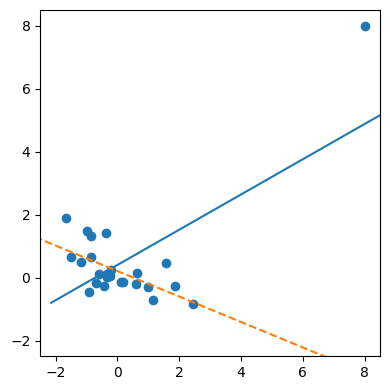

In [34]:
from scipy.stats import linregress

np.random.seed(5)
x = np.random.normal(size=25)
y = -x / 5 + np.random.normal(size=25)
x[0] = 8
y[0] = 8

def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x, y)
slope, intercept, _, _, _ = linregress(x, y)
ax.plot(*abline(slope, intercept, ax))
slope, intercept, _, _, _ = linregress(x[1:], y[1:])
ax.plot(*abline(slope, intercept, ax), '--')
ax.set_xlim(-2.5, 8.5)
ax.set_ylim(-2.5, 8.5)

plt.tight_layout()
plt.show()

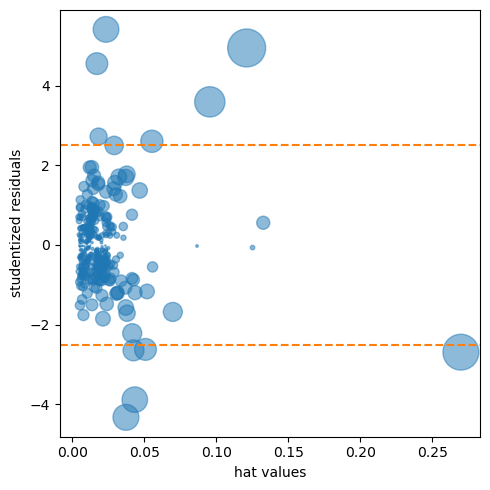

In [35]:
influence = OLSInfluence(result_98105)
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal,
           s=1000 * np.sqrt(influence.cooks_distance[0]),
           alpha=0.5)

ax.set_xlabel('hat values')
ax.set_ylabel('studentized residuals')

plt.tight_layout()
plt.show()

In [36]:
mask = [dist < .08 for dist in influence.cooks_distance[0]]
house_infl = house_98105.loc[mask]

ols_infl = sm.OLS(house_infl[outcome], house_infl[predictors].assign(const=1))
result_infl = ols_infl.fit()

pd.DataFrame({
    'Original': result_98105.params,
    'Influential removed': result_infl.params,
})

,Original,Influential removed
SqFtTotLiving,209.602346,230.052569
SqFtLot,38.933315,33.141600
Bathrooms,2282.264145,-16131.879785
Bedrooms,-26320.268796,-22887.865318
BldgGrade,130000.099737,114870.559737
const,-772549.862447,-647137.096716


```
데이터 수가 클 경우 어떤 값이 회귀방정식에 엄청난 변화를 가져오기 쉽지 않다.
```

### C. 이분산성, 비정규성, 오차 간 상관
---
- 잔차의 분포는 주로 공식적인 통계적 추론의 유효성과 관련이 있음
- (데이터 과학자들에게 잔차의 분포는 별로 중요하지 않음)
- 오차가 정규분포를 따른다면 모델이 완전하다는 신호
- 오차가 정규분포를 따르지 않는다면 모델에서 뭔가 누락되었을 수 있음을 의미
- <ins>형식적 추론이 완전히 유효하기 위한 잔차 조건</ins>
    1. 동일한 분산을 가짐
    1. 정규분포를 따름
    1. 서로 독립임
- 이분산성: 다양한 범위의 예측값에 따라 잔차의 분산이 일정하지 않은 것

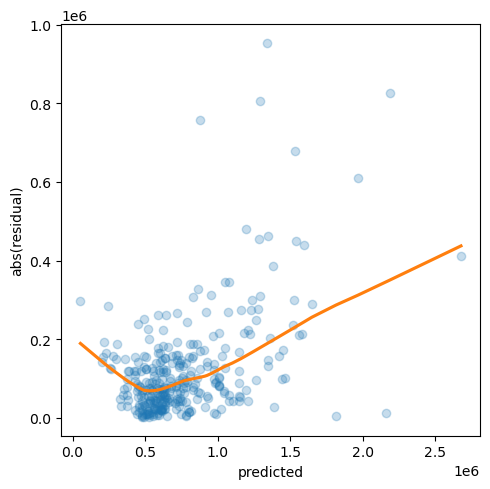

In [37]:
# 첫번째 가정 - 이분산성
# 절대잔차들을 부드럽게 연결하는 선 추가
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x=result_98105.fittedvalues, y=np.abs(result_98105.resid),
            scatter_kws={'alpha': 0.25},
            line_kws={'color': 'C1'},
            lowess=True, ax=ax)
ax.set_xlabel('predicted')
ax.set_ylabel('abs(residual)')

plt.tight_layout()
plt.show()

잔차의 분산이 고가와 저가의 주택일수록 증가하는 경향이 있다. <br>
이를 통해 이분산성 오차를 갖는다고 볼 수 있다.

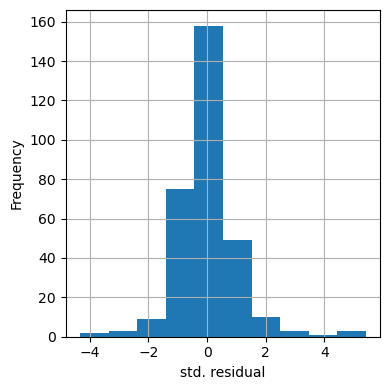

In [38]:
# 두번째 가정 - 히스토그램
fig, ax = plt.subplots(figsize=(4, 4))
pd.Series(influence.resid_studentized_internal).hist(ax=ax)
ax.set_xlabel('std. residual')
ax.set_ylabel('Frequency')


plt.tight_layout()
plt.show()

정규분포보다 확연히 더 긴 꼬리를 가지며, 더 큰 잔차에 대해 약간의 왜곡을 보인다.

```
※ 산점도 평활기(scatterplot smoother)

회귀모형을 평가할 때는 두 변수 사이의 관계를 시각적으로 강조하기 위해 산점도 평활기를 사용하는 것이 좋다.
평활화(smoothing): 연속적으로 부드럽게 변형 (loess 함수 등)
```

### D. 편잔차그림과 비선형성
---
- 편잔차그림: 예측 모델이 독립변수와 종속변수 간의 관계를 얼마나 잘 설명하는지 시각화하는 방법
    - 기본 개념 - 하나의 독립변수와 종속변수 사이의 관계를 모든 다른 독립변수로부터 분리하는 것
    - 독립변수 $X_i$의 편잔차 = 일반잔차에 $X_i$와 연관된 회귀항을 더한 값
    - $편잔차=잔차+\hat{b_i}X_i$

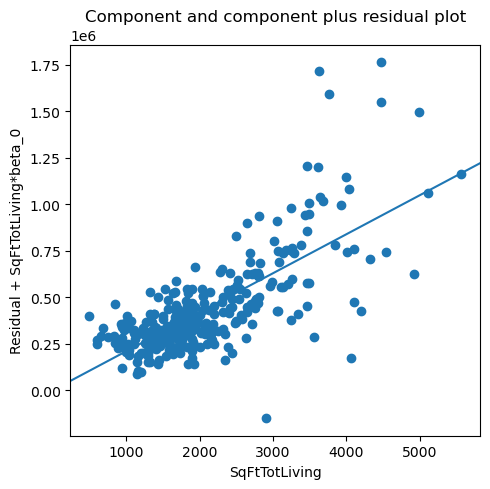

In [39]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = sm.graphics.plot_ccpr(result_98105, 'SqFtTotLiving', ax=ax)

plt.tight_layout()
plt.show()

- x축 = 독립변수 $X_i$
- y축 = 편잔차

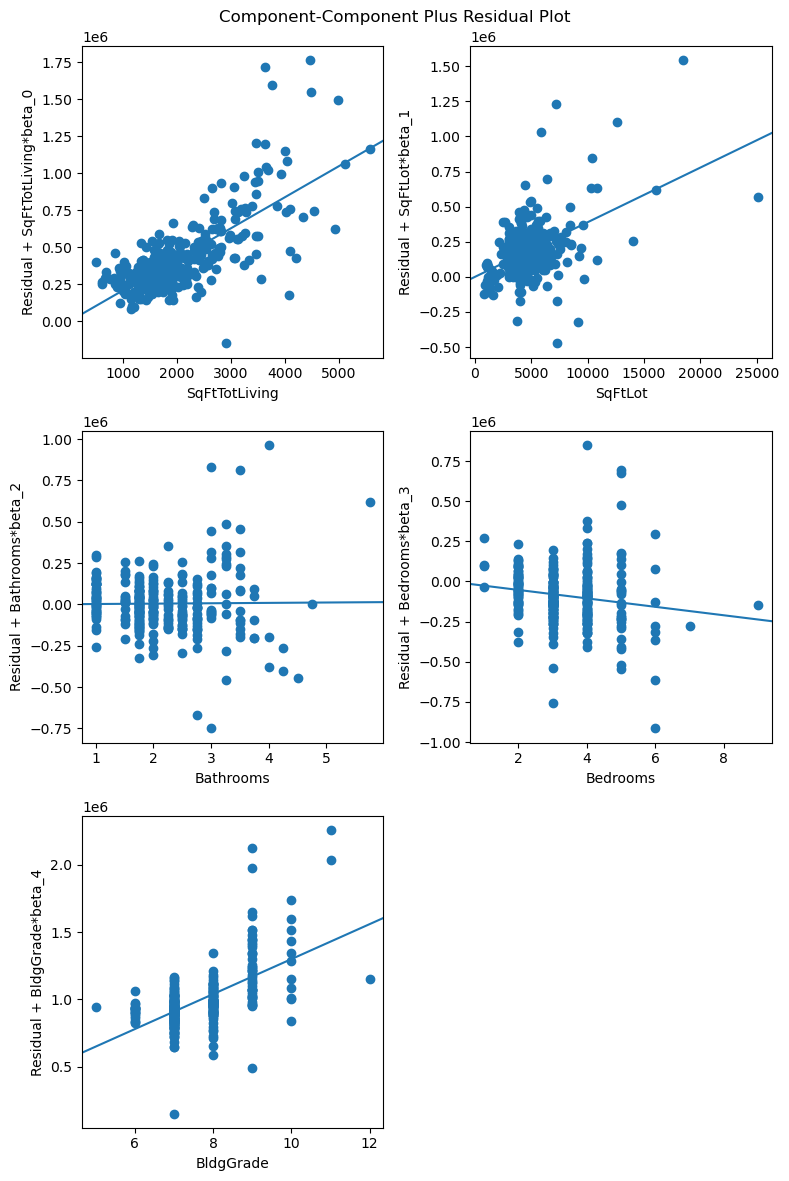

In [40]:
fig = plt.figure(figsize=(8, 12))
fig = sm.graphics.plot_ccpr_grid(result_98105, fig=fig)

## 7. 다항회귀와 스플라인 회귀
---
- 다항회귀(polynomial regression): 회귀모형에 다항식 항을 추가한 방식
- 스플라인 회귀(spline regression): 다항 구간들을 부드러운 곡선 형태로 fitting
- 매듭(knot): 스플라인 구간을 구분하는 값들
- 일반화가법모형(GAM): 자동으로 구간을 결정하는 스플라인 모델

### A. 다항회귀
---
- 이차 회귀식: $Y=b_0+b_1X+b_2X^2+e$

In [41]:
model_poly = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving + np.power(SqFtTotLiving, 2) + ' +
                'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
result_poly = model_poly.fit()
print(result_poly.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Fri, 07 Feb 2025   Prob (F-statistic):          9.95e-106
Time:                        15:40:16   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

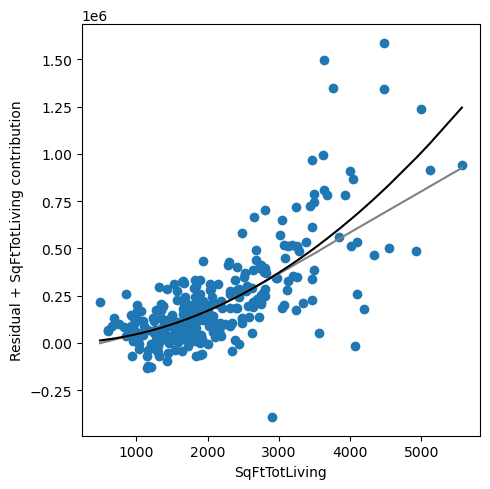

0.03879128168231151


In [42]:
# 비선형 편잔차분포 함수
def partialResidualPlot(model, df, outcome, feature, ax):
    y_pred = model.predict(df)
    # determine columns required for model
    required = set(model.params.index).intersection(df.columns)
    required.add(feature)
    copy_df = df[list(required)].copy().astype('float')
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df.loc[:, c] = 0.0
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': df[outcome] - y_pred,
        'ypartial': feature_prediction - model.params.iloc[0],
    })
    results = results.sort_values(by=['feature'])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)

    ax.scatter(results.feature, results.ypartial + results.residual)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='gray')
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_poly, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()
print(result_poly.params.iloc[2])

### B. 스플라인 회귀
---
- 스플라인: 고정된 점들 사이를 부드럽게 보간하는 방법

In [43]:
formula = ('AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + ' +
           'SqFtLot + Bathrooms + Bedrooms + BldgGrade')
model_spline = smf.ols(formula=formula, data=house_98105)
result_spline = model_spline.fit()
print(result_spline.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     131.8
Date:                Fri, 07 Feb 2025   Prob (F-statistic):          7.10e-104
Time:                        15:40:16   Log-Likelihood:                -4211.4
No. Observations:                 313   AIC:                             8445.
Df Residuals:                     302   BIC:                             8486.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


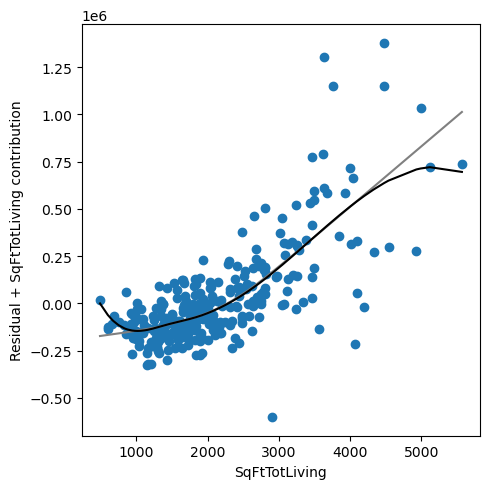

In [44]:
fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_spline, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()

### C. 일반화가법모형
---
- 다항회귀는 관계를 포착하기에 유연성이 부족할 수 있음
- 스플라인회귀는 매듭을 어디로 할지 정해줘야 함

##### a. statsmodels 사용

In [45]:
from statsmodels.gam.api import GLMGam, BSplines

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

x_spline = house_98105[predictors]
bs = BSplines(x_spline, df=[10] + [3] * 4, degree=[3] + [2] * 4)
# penalization weight
alpha = np.array([0] * 5)

formula = ('AdjSalePrice ~ SqFtTotLiving + ' +
           'SqFtLot + Bathrooms + Bedrooms + BldgGrade')

gam_sm = GLMGam.from_formula(formula, data=house_98105, smoother=bs, alpha=alpha)
res_sm = gam_sm.fit()

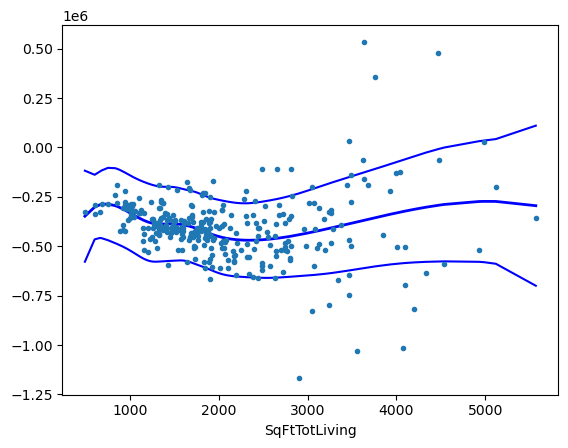

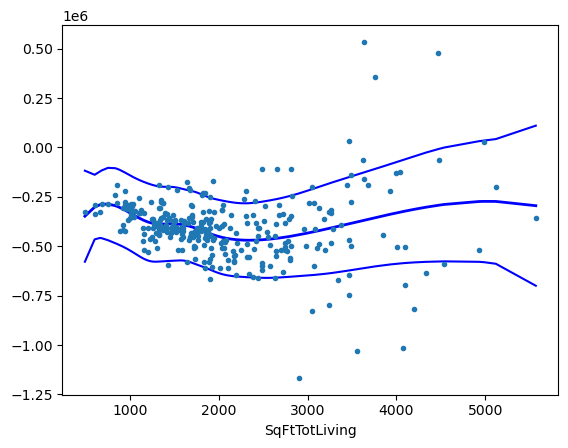

In [46]:
res_sm.plot_partial(0, cpr=True)

##### b. pyGAM 사용

In [47]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms',
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'
X = house_98105[predictors].values
y = house_98105[outcome]

## model
gam = LinearGAM(s(0, n_splines=12) + l(1) + l(2) + l(3) + l(4))
gam.gridsearch(X, y)
print(gam.summary())

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.6772
Link Function:                     IdentityLink Log Likelihood:                                 -7833.1159
Number of Samples:                          313 AIC:                                            15683.5863
                                                AICc:                                             15684.14
                                                GCV:                                      30838885095.1676
                                                Scale:                                    29480381715.8292
                                                Pseudo R-Squared:                                   0.8117
Feature Function                  Lam

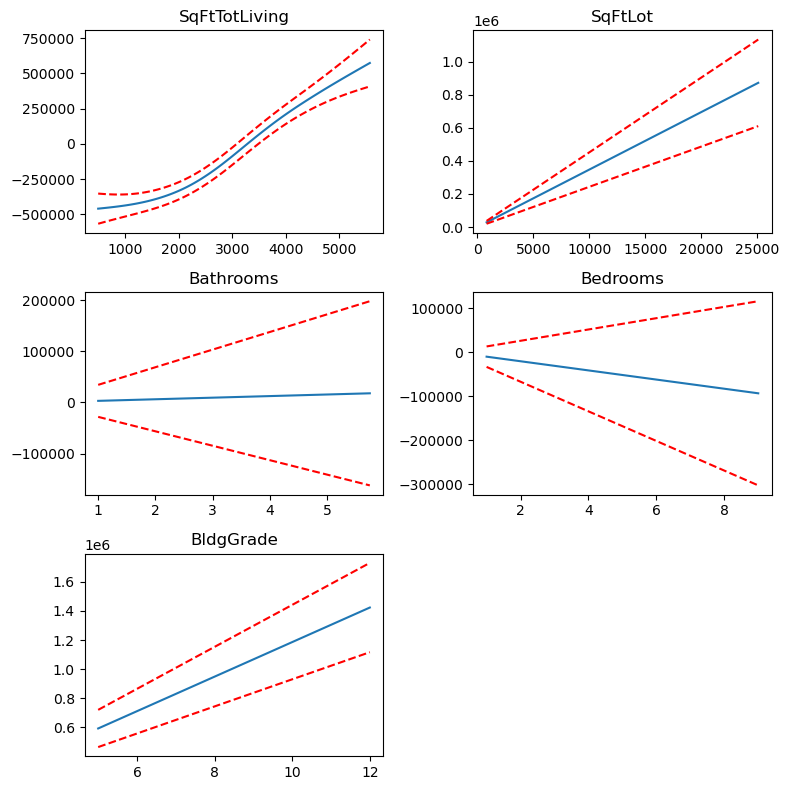

In [48]:
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=3)

titles = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
for i, title in enumerate(titles):
    ax = axes[i // 2, i % 2]
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i]);

axes[2][1].set_visible(False)

plt.tight_layout()
plt.show()